# Example of external photoevaporation setup.

Here we show how to implement external photoevaporation using the `setup_externalPhotoevaporation_FRIED()` routine, which loads the FRIED grid from [Haworth et al.(2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.481..452H/abstract) into `DustPy`, following the implementation of [Sellek et al.(2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.492.1279S/abstract)

The file `friedgrid.dat` is included in this module.

If you use this module please cite the papers above, in addition whith Garate et al.(in prep.), and Anania et al.(in prep.) for which this module was developed. 

In [1]:
import numpy as np
from dustpy import Simulation
from dustpy import constants as c

import matplotlib.pyplot as plt


A newer version of DustPy is available.
This version:   1.0.3
Latest version: 1.0.4

Upgrade with
pip install dustpy --upgrade



The two most important parameters parameters for the external photoevaporation setup are the stellar mass and the UV flux experienced by the disk.

* The stellar mass must be between $0.05\, M_\odot$ - $1.9\, M_\odot$.

* The UV flux must be between $10\, G_0$ - $10^4\, G_0$ 

The recommended radial limits for simulations using the FRIED grid are within 1 AU - 400 AU (i.e. the radial range covered by the grid).

In [2]:
sim = Simulation()
sim.ini.star.M = 1 * c.M_sun    # Stellar mass [g]
UV_flux = 1000                  # UV Flux [G0]

sim.ini.grid.rmin = 1 * c.au
sim.ini.grid.rmax = 400 * c.au

sim.initialize()

Now we call the setup routine as follows:

In [3]:
tmp_fried_path = './../../dustpylib/photoevaporation/external/friedgrid.dat'

In [4]:
from dustpylib.photoevaporation.external.setup_externalPhotoevaporation import setup_externalPhotoevaporation_FRIED
setup_externalPhotoevaporation_FRIED(sim, fried_filename = tmp_fried_path , UV_Flux = 1000.)

With this we are ready to run the simulation using `sim.run()`

## Sellek et al. (2020) model

What the `setup_externalPhotoevaporation_Fried` routine does behind the scenes is to create group called `FRIED`, where the calculations pertaining the photoevaporation grid are preformed. 

In [5]:
sim.FRIED

Group (FRIED grid used to calculate mass loss rates due to external photoevaporation)
-------------------------------------------------------------------------------------
    Table        : Group ((Resampled) Table of the mass loss rates for a given radial-Sigma grid.)
  -----
    MassLoss     : Field (Mass loss rate obtained by interpolating the FRIED Table at each grid cell [g/s])
    rTrunc       : Field (Truncation radius [cm])
  -----

In [6]:
sim.FRIED.Table

Group ((Resampled) Table of the mass loss rates for a given radial-Sigma grid.)
-------------------------------------------------------------------------------
    MassLoss     : Field (FRIED Mass loss rates [log10 (M_sun/year)] (grid, nr*nSigma))
    radii        : Field (Outer disk radius input to calculate FRIED mass loss rates [AU], (array, nr))
    Sigma        : Field (Surface density grid to calculate FRIED mass loss rates [g/cm^2] (array, nSigma))
  -----

The `FRIED.Table` contains a resampled version of the FRIED grid.
This table indicates the Mass Loss rate of the gas as a function of possible radii and densities of the outer disk.

The Table is constructed using following the instructions in Sellek et al.(2020), and then interpolating whithin the stellar mass and UV flux parameter space to match the simulation parameters.

Plotting the table as $\large \dot{M} = f(r_{out},\Sigma_{out})$ we obtain:

<Figure size 432x288 with 0 Axes>

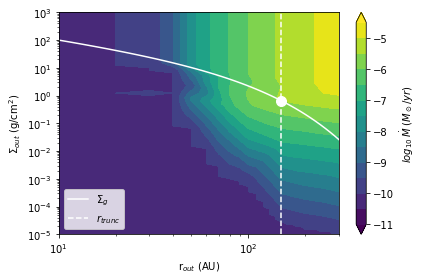

<Figure size 432x288 with 0 Axes>

In [7]:
plt.figure()
clim0 = -11.
clim1 = -4
levels = np.arange(clim0, clim1, .5)
cbarTicks = np.arange(clim0, clim1, 1.)


Table = sim.FRIED.Table 
plot00 = plt.contourf(
        Table.radii,
        Table.Sigma,
        Table.MassLoss.T,
        levels=levels,
        extend="both"
        )

plt.plot(sim.grid.r/c.au, sim.gas.Sigma, 'w', label = r'$\Sigma_{g}$')
plt.plot(sim.FRIED.rTrunc * np.ones(2)/c.au, [1.e-5, 1.e3], 'w--', label = "$r_{trunc}$")
plt.plot(sim.FRIED.rTrunc/c.au, sim.gas.Sigma[sim.grid.r.searchsorted(sim.FRIED.rTrunc)], 'wo', markersize = 10.)


plt.xlabel(r"r$_{out}$ (AU)")
plt.ylabel(r"$\Sigma_{out}$ (g/cm$^2$)")
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 300)
plt.ylim(1.e-5, 1.e3)
cbar00 = plt.colorbar(plot00)
cbar00.set_ticks(cbarTicks)
cbar00.ax.set_ylabel(r"$log_{10}\, \dot{M}$ ($M_\odot/yr$)")

plt.legend(loc = 3)
plt.tight_layout()

plt.figure()




The total mass loss rate that the disk will experience is calculated with the information from the regions outside the expected truncation radius $\large r_{trunc}$, which corresponds to the maximum of the mass loss rate map across the surface density of the disk.

In [8]:
print("Truncation Radius: {:.1f} AU".format(sim.FRIED.rTrunc/c.au))
print("Mass loss rate: {:.2e} Msun/yr ".format(sim.FRIED.MassLoss.max()/(c.M_sun/c.year)))

Truncation Radius: 148.9 AU
Mass loss rate: 3.21e-06 Msun/yr 


The mass loss rate is then spread over the disk outer regions such that:

$\Large \dot{M} = \int_{r_{trunc}}^\infty 2\pi r \dot{\Sigma}_{g} \mathrm{d}r$


with:
$\large \dot{\Sigma}_{g}(r < t_{trunc}) = 0$

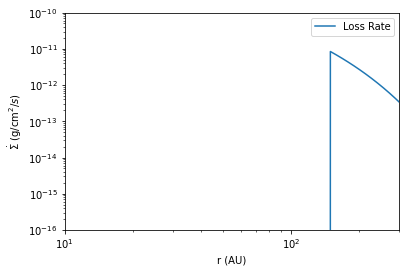

In [9]:
plt.figure()
plt.xlabel('r (AU)')
plt.ylabel(r'$\dot{\Sigma}$ (g/cm$^2/s$)')
plt.xlim([10, 300])
plt.ylim([1.e-16, 1.e-10])

plt.loglog(sim.grid.r/c.au, -sim.gas.S.ext, label = 'Loss Rate')
plt.legend()

## Dust entrainment

In addition to the gas loss term and  the FRIED group, the setup routine also determines which grain sizes are entrained the photoevaporative winds (see Facchini et al.(2016), Sellek et al.(2020))

$\Large a_{ent} = \frac{v_{th}}{G M_*}   \frac{\dot{M}}{4\pi F \rho_s}$ 

with $v_{th}$ the thermal speed, $F$ the fraction of solid angle comprised by the disk, and $\rho_s$ the dust material density. 

The dust loss rate is then calculated as:

$\Large \dot{\Sigma}_{d} = f_{ent}\, \epsilon\, \dot{\Sigma}_{g}$,

with $\epsilon$ the local dust-to-gas ratio, and $f_{ent}(a < a_{ent}) = 1$, or $0$ otherwise

## Gas only example

To illustrate the effect of the external photoevaporation in the disk global evolution we perform here a quick simulation with the dust evolution de-activated.

In [10]:
sim = Simulation()
sim.ini.star.M = 1 * c.M_sun    # Stellar mass [g]
UV_flux = 1000                  # UV Flux [G0]

sim.ini.grid.rmin = 10 * c.au
sim.ini.grid.rmax = 400 * c.au

# We won't need the dust component, so we shrink the mass grid to save computational resources
sim.ini.grid.Nmbpd = 1
sim.ini.grid.mmax = 1.e-10

sim.initialize()

In [11]:
setup_externalPhotoevaporation_FRIED(sim, fried_filename = tmp_fried_path, UV_Flux = 1000.)

We disable the dust sources calculations, and remove turn-off the option of the dust related quantities

In [12]:
from simframe.frame import Field, Group
sim.dust.S.coag[...] = 0.
sim.dust.S.coag.updater = None
sim.dust.S.ext[...] = 0.
sim.dust.S.ext.updater = None
sim.dust.S.hyd[...] = 0.
sim.dust.S.hyd.updater = None
sim.dust.S.tot[...] = 0.
sim.dust.S.tot.updater = None
sim.dust.S.updater = None
sim.dust.updater = None

# Do not save the Fields in the dust Group or subGroups
sim.dust.save = False
for key, val in sim.dust.__dict__.items():
    if isinstance(val, Field):
        field = val
        field.save = False
    elif isinstance(val, Group):
        group = val
        for key_group, val_group in group.__dict__.items():
            if isinstance(val_group, Field):
                field = val_group
                field.save = False        
sim.t.save = True

In [13]:
sim.writer.datadir = "./photoevaporation_examples/externalPhotoevaporation_gasonly/" 
sim.t.snapshots = np.array([1.e4, 1.e5, 1.e6]) * c.year

sim.writer.dumping = False
sim.writer.overwrite = True
sim.writer.verbosity = 2

Now we execute `sim.run()` and proceed to plot the evolution of the gas surface density.

In [14]:
from dustpy import hdf5writer
hdf5writer = hdf5writer() 

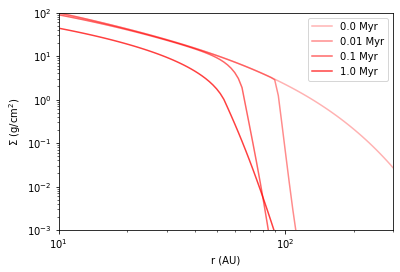

In [15]:
hdf5writer.datadir = sim.writer.datadir

times= hdf5writer.read.sequence("t")
r = hdf5writer.read.sequence("grid.r")[0]
Sigma_g = hdf5writer.read.sequence("gas.Sigma")

plt.figure()
plt.xlim([10,300])
plt.ylim([1.e-3, 1.e2])


plt.xlabel("r (AU)")
plt.ylabel(r"$\Sigma$ (g/cm$^2)$")


for snap in range(0,len(times)):
    # Plot simulation
    alpha_min = 0.15
    alpha_max = 0.75
    alpha_line = alpha_min +  (snap+1)/len(times) *(alpha_max - alpha_min) 
    plt.loglog(r/c.au, Sigma_g[snap], 'r', alpha = alpha_line, label = str(np.round(times[snap]/c.year/1.e6,2)) + " Myr")
    
plt.legend()

The plot above illustrates how external photoevaporation quickly truncates the outer disk during the first 0.1 Myr of evolution. 

Afterwards the disk evolves viscously, though photoevaporation prevents the disk from fully spreading.